In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

# configure the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load the dataset
MNIST database is a collection of 70000 handwritten digits split into training and test set of 60000 and 10000 grayscale 28x28 images respectively.

In [ ]:
# pre-processing pipeline: Transform each image to a pytorch tensor then normalize it to get global mean=0.0 and std=1.0
transform=Compose([ToTensor(), Normalize((0.0,), (1.0,))])

# Load training data
training = datasets.MNIST( root='/content/data/', train=True, download=True, transform=transform)

# printthe taining_data
print(training)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.0,), std=(1.0,))
           )


In [ ]:
len(training)

60000

In [ ]:
training.targets.shape

torch.Size([60000])

In [ ]:
training.data.shape

torch.Size([60000, 28, 28])

**Q1-** Show the 9 first training images (using plt.subplot, plt.imshow, plt.title) and their labels as titles

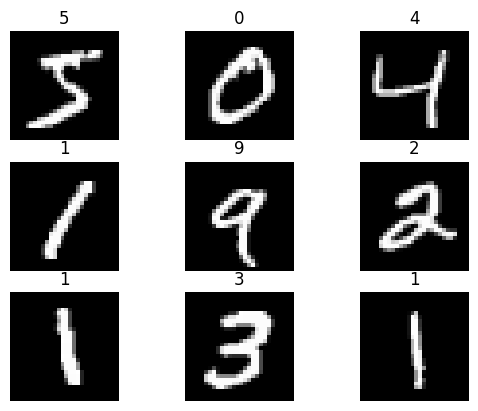

In [ ]:
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(training.data[i], cmap='gray')
  plt.axis('off')
  plt.title(training.targets[i].item())
plt.show()

**Q2-** Load the test data

In [ ]:
# Load testing_data
testing = datasets.MNIST( root='/content/data/', train=False, download=True, transform=transform)

# print the testing data
print(testing)

Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.0,), std=(1.0,))
           )


**Q3-** Create DataLoaders for training_data and testing_data

In [ ]:
batch_size = 256
# Training dataloader
train_dl = DataLoader(training, batch_size=batch_size, shuffle=True)
# Testing dataloader
test_dl = DataLoader(testing, batch_size=batch_size, shuffle=False)

# Build a MLP Model

**Q4-** Build a MLP model with 2 hidden Layers with respectively 250 and 100 neurons using ReLU activation function.
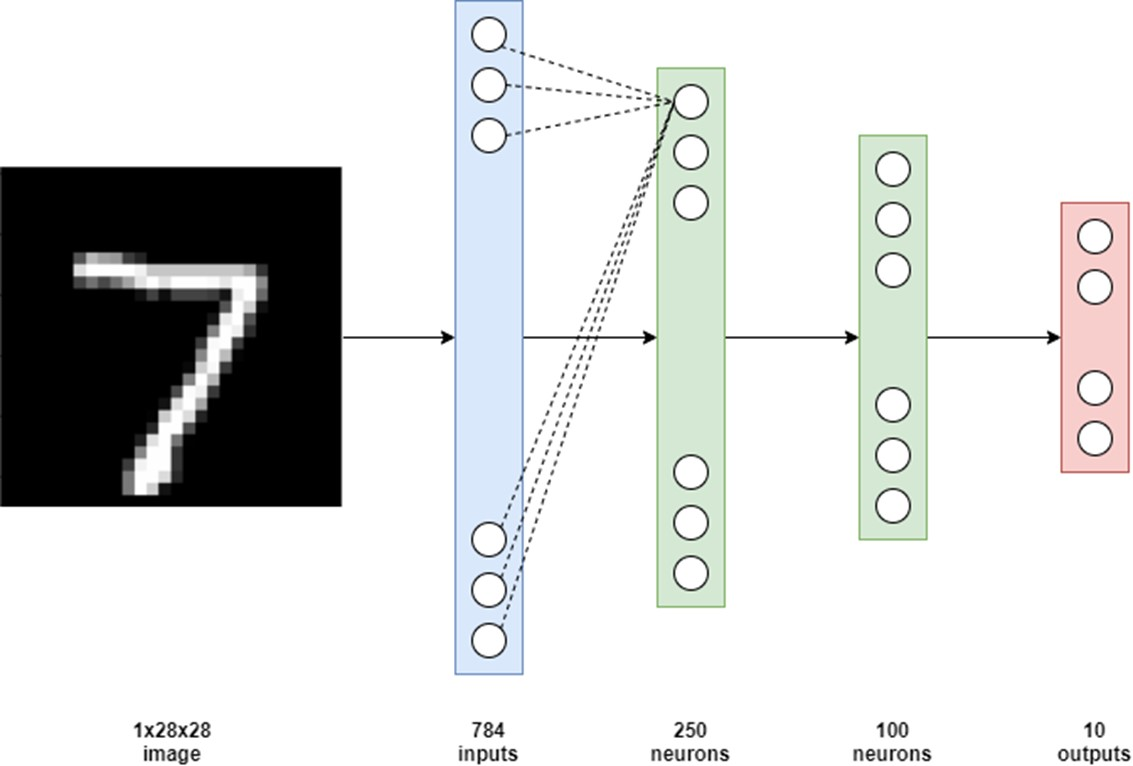

In [ ]:
class MLP1(nn.Module):
  # Your code here
  def __init__(self, N1, N2):
    super(MLP1, self).__init__()
    self.fc1 = nn.Linear(28*28,N1)
    self.fc2 = nn.Linear(N1,N2)
    self.fc3 = nn.Linear(N2,10)

  def forward(self, x):
    # Your code here
    x = x.view(-1,28*28) # reshape 28x28 image to a vector
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.fc3(x)
    return out

# create a MLP1 model
model1 = MLP1(250, 100)

**Q5-** Move the model to the device.

In [ ]:
model1.to(device)

MLP1(
  (fc1): Linear(in_features=784, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
# print the model's summary
summary(model1, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 250]         196,250
            Linear-2                  [-1, 100]          25,100
            Linear-3                   [-1, 10]           1,010
Total params: 222,360
Trainable params: 222,360
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.85
Estimated Total Size (MB): 0.85
----------------------------------------------------------------


# Model Training

**Q6-** Define a train function 'train_model' which print the total loss each epoch.

In [ ]:
def train_one_epoch(model, data_dl, gd_optim, device):
  loss_fn = nn.CrossEntropyLoss()
  model.train() # set train mode
  train_loss = 0
  for xb, yb in data_dl:
    # move xb & yb to device
    xb = xb.to(device)
    yb = yb.to(device)
    # get prediction
    preds = model(xb)
    # compute Cross-entropy loss
    loss = loss_fn(preds, yb)
    # compute gradients
    loss.backward()
    # update weights
    gd_optim.step()
    # reset the optimizer to zero
    gd_optim.zero_grad()
    train_loss += torch.sum(loss).item()
  return train_loss, model

In [ ]:
def train_model(model, train_dl, epochs, lr, device):
  optimizer = optim.Adam(model.parameters(), lr=lr)
  losses = np.zeros(epochs)
  for epoch in range(epochs):
    losses[epoch], model = train_one_epoch(model, train_dl, optimizer, device)
    print("epoch", epoch, "Train_Loss", losses[epoch])
  return losses, model

# Hyper-parameters
lr = 0.01    # the learning rate
epochs = 10  # number of epochs

losses, model1 = train_model(model1, train_dl, epochs, lr, device)

epoch 0 Train_Loss 57.23656493425369
epoch 1 Train_Loss 23.87261714786291
epoch 2 Train_Loss 18.74701988371089
epoch 3 Train_Loss 15.600145631469786
epoch 4 Train_Loss 13.60652737878263
epoch 5 Train_Loss 13.239046385046095
epoch 6 Train_Loss 11.192561646923423
epoch 7 Train_Loss 10.756524701137096
epoch 8 Train_Loss 11.322139482479542
epoch 9 Train_Loss 9.572730204439722


**Q7-** Plot the loss curve of the training phase.

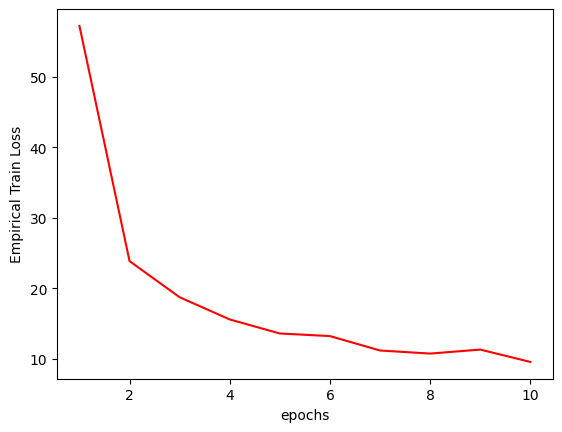

In [ ]:
plt.plot(range(1,epochs+1), losses, 'r')
plt.xlabel('epochs')
plt.ylabel('Empirical Train Loss')
plt.show()

# Model Evaluation
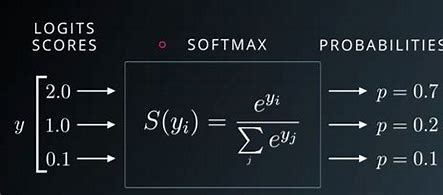

**Q8-** define a function "predict" which returns predictions of testing data.

In [ ]:
def predict(model, data_dl, device):
  ypreds = []
  ytrue = []
  val_loss = 0.0
  loss_fn = nn.CrossEntropyLoss()
  model.eval() # set the evaulation mode
  with torch.no_grad():
    for xb, yb in data_dl:
      # move xb & yb to device
      xb = xb.to(device)
      yb = yb.to(device)
      # get prediction logits
      logits = model(xb)
      # compute Cross-entropy loss
      loss = loss_fn(logits, yb)
      # update val_loss
      val_loss += torch.sum(loss).item()
      ypreds = np.concatenate((ypreds, logits.argmax(1).cpu().numpy()), axis=0)
      ytrue = np.concatenate((ytrue, yb.cpu().numpy()), axis=0)
  return val_loss, ytrue, ypreds

**Q9-** By using sklearn.metrics, compute and print the accuracy of the model.

In [ ]:
from sklearn.metrics import accuracy_score
val_loss, ytrue, ypreds  =  predict(model1, test_dl, device)
print("validation Loss", val_loss)
print("Model's accuracy : ", accuracy_score(ytrue, ypreds))

validation Loss 4.1553644599816835
Model's accuracy :  0.9754


In [ ]:
# save the model
torch.save(model1, './mnist_model_1.pt')

# Improving the performance by regularization

**Q10-** Define a new model MLP2 by adding dropout(0.5) to its hidden layers

In [ ]:
class MLP2(nn.Module):
  # Your code here
  def __init__(self, N1, N2):
    super(MLP2, self).__init__()
    self.fc1 = nn.Linear(28*28,N1)
    self.fc2 = nn.Linear(N1,N2)
    self.fc3 = nn.Linear(N2,10)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    # Your code here
    x = x.view(-1,28*28) # reshape 28x28 image to a vector
    x = self.dropout(F.relu(self.fc1(x)))
    x =self.dropout(F.relu(self.fc2(x)))
    out = self.fc3(x)
    return out

# create a MLP2 model
model2 = MLP2(250, 100)
# move model2 to device
model2 = model2.to(device)
# print the model's summary
summary(model2, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 250]         196,250
           Dropout-2                  [-1, 250]               0
            Linear-3                  [-1, 100]          25,100
           Dropout-4                  [-1, 100]               0
            Linear-5                   [-1, 10]           1,010
Total params: 222,360
Trainable params: 222,360
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.85
Estimated Total Size (MB): 0.86
----------------------------------------------------------------


**Q11-** Train the model with Early Stopping regularization

In [ ]:
def train_model_early_stopping(model, train_dl, test_dl, epochs, lr, device):
  train_losses = []
  val_losses = []
  last_loss = 1000
  triggertimes = 0
  patience = 3
  optimizer = optim.Adam(model.parameters(), lr=lr)

  for epoch in range(epochs):
    train_loss, model = train_one_epoch(model, train_dl, optimizer, device)
    train_losses.append(train_loss)
    current_loss, ytrue, ypreds =  predict(model, test_dl, device)
    val_losses.append(current_loss)
    # Early Stopping
    if current_loss > last_loss:
      triggertimes += 1
      print('trigger times', triggertimes)
    if triggertimes >= patience:
      print('Perform Early stopping!')
      return losses, val_losses, model
    else:
      trigger_times = 0
      print('trigger times', triggertimes)

    last_loss = current_loss
    print("epoch", epoch, "train_Loss", train_losses[epoch], "val_Loss", val_losses[epoch])

  return train_losses, val_losses, model

# Hyper-parameters
lr = 0.01    # the learning rate
epochs = 100  # number of epochs
train_losses, val_losses, model2 = train_model_early_stopping(model2, train_dl, test_dl, epochs, lr, device)

trigger times 0
epoch 0 train_Loss 106.85914954543114 val_Loss 7.567097809165716
trigger times 0
epoch 1 train_Loss 73.7189157307148 val_Loss 5.806220984552056
trigger times 0
epoch 2 train_Loss 66.99618491530418 val_Loss 5.465267261257395
trigger times 0
epoch 3 train_Loss 63.92146381735802 val_Loss 5.3386069922707975
trigger times 1
trigger times 1
epoch 4 train_Loss 60.33767207711935 val_Loss 5.79946775874123
trigger times 1
epoch 5 train_Loss 59.11920718103647 val_Loss 4.931872844696045
trigger times 2
trigger times 2
epoch 6 train_Loss 56.83811865001917 val_Loss 6.411498333327472
trigger times 2
epoch 7 train_Loss 57.04222393035889 val_Loss 5.105563063058071
trigger times 3
Perform Early stopping!


**Q12-** Plot the two curves of losses and val_losses

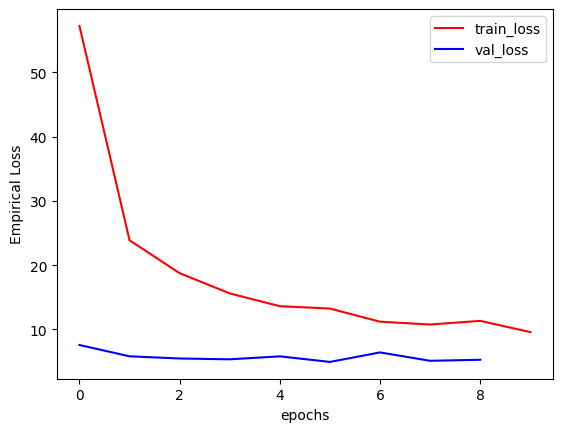

In [ ]:
plt.plot(range(len(train_losses)), train_losses, 'r', label = 'train_loss')
plt.plot(range(len(val_losses)), val_losses, 'b', label='val_loss')
plt.xlabel('epochs')
plt.ylabel('Empirical Loss')
plt.legend(loc = 'upper right')
plt.show()

**Q13-** Evaluate this model on test data and save it

In [ ]:
from sklearn.metrics import accuracy_score
val_loss, ytrue, ypreds  =  predict(model2, test_dl, device)
print("validation Loss", val_loss)
print("Model's accuracy : ", accuracy_score(ytrue, ypreds))

validation Loss 5.268535336013883
Model's accuracy :  0.9637


In [ ]:
# save the model
torch.save(model2, './mnist_model_2.pt')